---
title: "Some Time Serfor `matplotlib`"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2024-6-15"
draft: true
categories: ['Python']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [ ]:
df_stations = df.groupby(['Date', 'End'])['Riders'].sum().compute()
df_stations = df_stations.reset_index()
df_stations.head()

,Date,End,Riders
0,2011-01-01,12TH,2589
1,2011-01-01,16TH,4490
2,2011-01-01,19TH,2157
3,2011-01-01,24TH,5212
4,2011-01-01,ASHB,2155


In [ ]:
station_name_crosswalk = pd.read_csv("station_names.csv")
station_name_crosswalk['Abbr'] = station_name_crosswalk['Abbr'].str.upper()
station_name_crosswalk.head()

,Abbr,Station Name
0,12TH,12th St. Oakland City Center
1,16TH,16th St. Mission (SF)
2,19TH,19th St. Oakland
3,24TH,24th St. Mission (SF)
4,ASHB,Ashby (Berkeley)


In [ ]:
df_stations_merge = df_stations.merge(station_name_crosswalk, left_on='End', right_on='Abbr', how="left").drop(columns=['Abbr'])
df_stations_merge.head()

,Date,End,Riders,Station Name
0,2011-01-01,12TH,2589,12th St. Oakland City Center
1,2011-01-01,16TH,4490,16th St. Mission (SF)
2,2011-01-01,19TH,2157,19th St. Oakland
3,2011-01-01,24TH,5212,24th St. Mission (SF)
4,2011-01-01,ASHB,2155,Ashby (Berkeley)


In [ ]:
stations = gpd.read_file("California_Rail_Stations.geojson")
bart_stations = stations[stations['COMM_OP'] == "BART"]
bart_stations.head()

,OBJECTID,LOCATION,STATION,CODE,ADDRESS,ZIP,PASS_OP,PASS_NETWO,COMM_OP,COMM_NETWO,BUS_ROUTES,TRANSIT,AIRPORT,STATION_TY,INTERMODAL,DIST,CO,geometry
52,53,BART Station,DUBLIN/PLEASANTON,DBP,I-580 at Hopyard (Mid-Day Parking),94588,,,BART,BART,"6,34",,,3,1,4,ALA,POINT (-121.89849 37.70247)
212,213,,NORTH BERKELEY,,,0,,,BART,BART,,,,1,0,4,ALA,POINT (-122.28335 37.87406)
213,214,,DOWNTOWN BERKELEY,,,0,,,BART,BART,,,,1,0,4,ALA,POINT (-122.26825 37.86969)
214,215,,ASHBY,,,0,,,BART,BART,,,,1,0,4,ALA,POINT (-122.27012 37.85321)
215,216,,ROCKRIDGE,,,0,,,BART,BART,,,,1,0,4,ALA,POINT (-122.25178 37.84451)


In [ ]:
from rapidfuzz.process import extractOne
from rapidfuzz.distance import Levenshtein, JaroWinkler

In [ ]:
Levenshtein.normalized_distance("peter", "peterd")

0.16666666666666666

In [ ]:
Levenshtein.normalized_distance("peter", "dpeter")

0.16666666666666666

In [ ]:
JaroWinkler.normalized_distance("peter", "dpeter")

0.05555555555555547

In [ ]:
JaroWinkler.normalized_distance("peter", "peterd")

0.033333333333333326

In [ ]:
def match_dict(left_series: pd.Series, right_series: pd.Series, scoring=Levenshtein.distance):
    mapping = pd.Series({
        index: right_series.unique()[extractOne(index.lower(), right_series.str.lower().unique(), scorer=scoring)[-1]]
        for index in left_series
        })
    return mapping

In [ ]:
match_dict(bart_stations['STATION'], df_stations_merge['Station Name'], scoring=JaroWinkler.normalized_distance)

DUBLIN/PLEASANTON                            Dublin/Pleasanton
NORTH BERKELEY                                  North Berkeley
DOWNTOWN BERKELEY                            Downtown Berkeley
ASHBY                                         Ashby (Berkeley)
ROCKRIDGE                                  Rockridge (Oakland)
MACARTHUR                                  MacArthur (Oakland)
19TH STREET/OAKLAND                           19th St. Oakland
WEST OAKLAND                                      West Oakland
12TH ST/OAKLAND CITY CENTER       12th St. Oakland City Center
LAKE MERRITT                            Lake Merritt (Oakland)
FRUITVALE                                  Fruitvale (Oakland)
COLISEUM/OAKLAND AIRPORT (OAK)                        Coliseum
SAN LEANDRO                                        San Leandro
BAY FAIR                                Bay Fair (San Leandro)
CASTRO VALLEY                                    Castro Valley
HAYWARD                                                

In [ ]:
df_stations_merge['Station Name']

0         12th St. Oakland City Center
1                16th St. Mission (SF)
2                     19th St. Oakland
3                24th St. Mission (SF)
4                     Ashby (Berkeley)
                      ...             
227151                      Union City
227152      Warm Springs/South Fremont
227153                    Walnut Creek
227154                     West Dublin
227155                    West Oakland
Name: Station Name, Length: 227156, dtype: object

In [ ]:
{index: extractOne(index.lower(), df_stations_merge['Station Name'].str.lower().unique(), scorer=JaroWinkler.distance)[-1] for index in bart_stations['STATION']}

{'DUBLIN/PLEASANTON': ('dublin/pleasanton', 0.0, 15),
 'NORTH BERKELEY': ('north berkeley', 0.0, 26),
 'DOWNTOWN BERKELEY': ('downtown berkeley', 0.0, 13),
 'ASHBY': ('ashby (berkeley)', 0.13749999999999996, 4),
 'ROCKRIDGE': ('rockridge (oakland)', 0.10526315789473684, 34),
 'MACARTHUR': ('macarthur (oakland)', 0.10526315789473684, 23),
 '19TH STREET/OAKLAND': ('19th st. oakland', 0.07763157894736838, 2),
 'WEST OAKLAND': ('west oakland', 0.0, 42),
 '12TH ST/OAKLAND CITY CENTER': ('12th st. oakland city center',
  0.06784696784696786,
  0),
 'LAKE MERRITT': ('lake merritt (oakland)', 0.09090909090909094, 22),
 'FRUITVALE': ('fruitvale (oakland)', 0.10526315789473684, 18),
 'COLISEUM/OAKLAND AIRPORT (OAK)': ('coliseum', 0.14666666666666672, 10),
 'SAN LEANDRO': ('san leandro', 0.0, 35),
 'BAY FAIR': ('bay fair (san leandro)', 0.1272727272727272, 6),
 'CASTRO VALLEY': ('castro valley', 0.0, 7),
 'HAYWARD': ('hayward', 0.0, 20),
 'SOUTH HAYWARD': ('south hayward', 0.0, 38),
 'UNION CITY'

In [ ]:
test = pd.Series({index: extractOne(index.lower(), df_stations_merge['Station Name'].str.lower().unique(), scorer=JaroWinkler.distance)[0] for index in bart_stations['STATION']})

In [ ]:
test.reset_index() df_stations_merge['Station Name'].str.lower()

,index,0
0,DUBLIN/PLEASANTON,dublin/pleasanton
1,NORTH BERKELEY,north berkeley
2,DOWNTOWN BERKELEY,downtown berkeley
3,ASHBY,ashby (berkeley)
4,ROCKRIDGE,rockridge (oakland)
5,MACARTHUR,macarthur (oakland)
6,19TH STREET/OAKLAND,19th st. oakland
7,WEST OAKLAND,west oakland
8,12TH ST/OAKLAND CITY CENTER,12th st. oakland city center
9,LAKE MERRITT,lake merritt (oakland)


In [ ]:
bart_stations['STATION']

52                  DUBLIN/PLEASANTON
212                    NORTH BERKELEY
213                 DOWNTOWN BERKELEY
214                             ASHBY
215                         ROCKRIDGE
216                         MACARTHUR
217               19TH STREET/OAKLAND
218                      WEST OAKLAND
219       12TH ST/OAKLAND CITY CENTER
220                      LAKE MERRITT
221                         FRUITVALE
222    COLISEUM/OAKLAND AIRPORT (OAK)
223                       SAN LEANDRO
224                          BAY FAIR
225                     CASTRO VALLEY
226                           HAYWARD
227                     SOUTH HAYWARD
228                        UNION CITY
229                           FREMONT
230               PITTSBURG/BAY POINT
231            NORTH CONCORD/MARTINEZ
232                           CONCORD
233              EL CERRITO DEL NORTE
234    PLEASANT HILL/CONTRA COSTA CEN
235                  EL CERRITO PLAZA
236                      WALNUT CREEK
237         

In [ ]:
df_stations['Station Name'].unique()

array(['12th St. Oakland City Center', '16th St. Mission (SF)',
       '19th St. Oakland', '24th St. Mission (SF)', 'Ashby (Berkeley)',
       'Balboa Park (SF)', 'Bay Fair (San Leandro)', 'Castro Valley',
       'Civic Center (SF)', 'Colma', 'Coliseum', 'Concord', 'Daly City',
       'Downtown Berkeley', 'El Cerrito del Norte', 'Dublin/Pleasanton',
       'Embarcadero (SF)', 'Fremont', 'Fruitvale (Oakland)',
       'Glen Park (SF)', 'Hayward', 'Lafayette', 'Lake Merritt (Oakland)',
       'MacArthur (Oakland)', 'Millbrae', 'Montgomery St. (SF)',
       'North Berkeley', 'North Concord/Martinez', 'Orinda',
       'Pleasant Hill', 'Pittsburg/Bay Point', 'El Cerrito Plaza',
       'Powell St. (SF)', 'Richmond', 'Rockridge (Oakland)',
       'San Leandro', 'San Bruno', "San Francisco Int'l Airport",
       'South Hayward', 'South San Francisco', 'Union City',
       'Walnut Creek', 'West Oakland', 'West Dublin',
       "Oakland Int'l Airport", 'Warm Springs/South Fremont', 'Antioch',
    

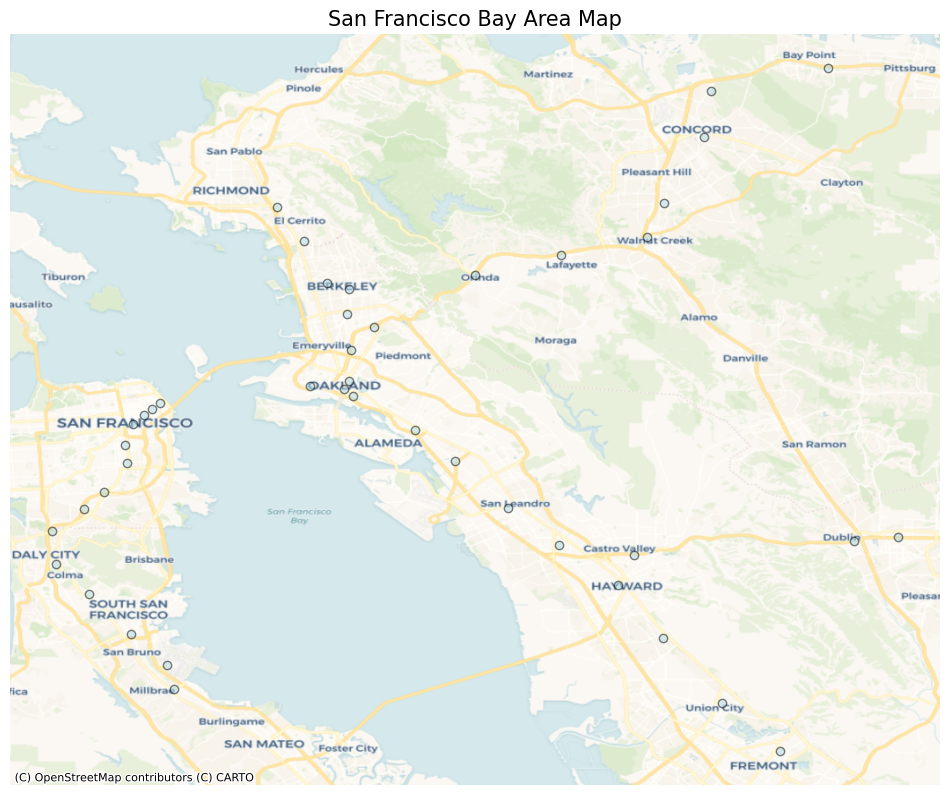

In [ ]:


# Load the shapefile of California (replace 'path_to_shapefile' with your file path)
# For this example, we'll use a built-in GeoPandas dataset.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
california = world[world.name == 'United States']

# Using a predefined boundary of the Bay Area (you may need to customize this)
bay_area_counties = ['San Francisco', 'San Mateo', 'Santa Clara', 'Alameda', 'Contra Costa', 'Solano', 'Napa', 'Sonoma', 'Marin']

# Load the counties shapefile (you need to have a shapefile of counties)
stations = gpd.read_file("California_Rail_Stations.geojson")
bart_stations = stations[stations['COMM_OP'] == "BART"]


# Plot the Bay Area map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
bart_stations.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.5)
ctx.add_basemap(ax, crs=bart_stations.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
ax.set_title('San Francisco Bay Area Map', fontsize=15)
ax.set_axis_off();
